# Predecir el Puntaje de Recencia en Papers de Investigación
*Notebook created by Erick Calderin*

**Web site:** https://www.datasource.ai/es/home/data-science-competitions-for-startups/predecir-el-puntaje-de-recencia-en-papers-de-investigacion

## Modules

In [1]:
# Utilities

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# For ML
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
import multiprocessing as mp

For NLP

In [4]:
# Install
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!python -m spacy download pt_core_news_sm

  Attempting uninstall: spacy
    Found existing installation: spacy 3.1.1
    Uninstalling spacy-3.1.1:
      Successfully uninstalled spacy-3.1.1


You should consider upgrading via the 'c:\users\erick\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-08-31 01:37:03.303834: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
You should consider upgrading via the 'C:\Users\Erick\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


2021-08-31 01:37:23.791077: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
You should consider upgrading via the 'C:\Users\Erick\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


2021-08-31 01:37:36.335597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
You should consider upgrading via the 'C:\Users\Erick\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
import spacy
import re
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

## Importing data

Getting training and test datasets from Drive.

In [4]:
# Train
#PREFIX = '/content/drive/MyDrive/Colab Notebooks/CompetenciaPuntajeRecencia'
#train = pd.read_csv(PREFIX+'/Train.csv')
#test = pd.read_csv(PREFIX+'/Test.csv')

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

## Exploring

In [5]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score
0,1,en,2016,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682
1,2,en,2019,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333
2,3,en,2019,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222
3,4,en,2017,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765
4,5,en,2015,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737


In [6]:
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (21456, 6)
Test Shape (10728, 5)


In [7]:
print('Unique languages\n', train.Language.value_counts())
print('\nAmount Unique Years', len(train.Year.value_counts()))

Unique languages
 en    18539
pt     1539
es     1378
Name: Language, dtype: int64

Amount Unique Years 59


No missing values!

In [8]:
train.isna().sum()

id                 0
Language           0
Year               0
Abstract           0
Title              0
total_rel_score    0
dtype: int64

Score distribution for each language

Text(0.5, 6.79999999999999, 'Scores')

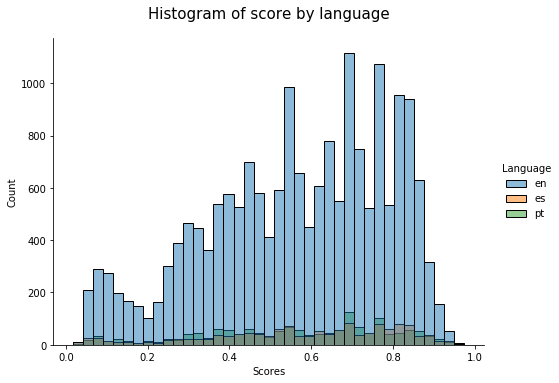

In [12]:
sns.displot(data=train, x= 'total_rel_score', aspect=1.4, hue='Language')
plt.title('Histogram of score by language', fontsize=15, pad=20)
plt.xlabel('Scores')

Plot above indicate us there is no outliers within data, another great new! However we can notice that papers at english language overcome to ones created in other languages.

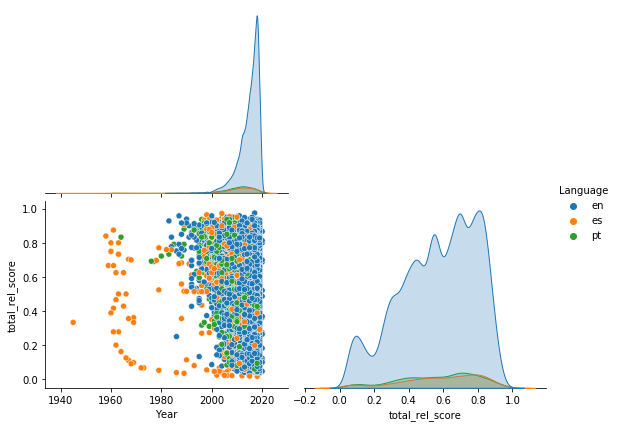

In [13]:
sns.pairplot(train.drop(columns=['id']), hue='Language', corner=True, aspect=1.3, height=3)

In another hand, there is a clear separation between papers at spanish language in early years and rest of papers.

## Preprocessing

### Creating dummy variables for Language

In [5]:
dummy_language = OneHotEncoder(dtype='int8')
df_dummy_language = dummy_language.fit_transform(train[['Language']]).toarray()

In [6]:
train = train.join(pd.DataFrame(df_dummy_language, columns=dummy_language.categories_[0]))

### MinMaxScaler to Year

In [7]:
minMaxScaler = MinMaxScaler()
year_minmax = minMaxScaler.fit_transform(train[['Year']])
train.Year = year_minmax

In [8]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score,en,es,pt
0,1,en,0.946667,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682,1,0,0
1,2,en,0.986667,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333,1,0,0
2,3,en,0.986667,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222,1,0,0
3,4,en,0.960000,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765,1,0,0
4,5,en,0.933333,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737,1,0,0


### Applying NLP

##### Tokenizing

In [13]:
# Loading spacy for every target language
nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load('es_core_news_sm')
nlp_pt = spacy.load('pt_core_news_sm')

stem_en = SnowballStemmer(language='english')
stem_es = SnowballStemmer(language='spanish')
stem_pt = SnowballStemmer(language='portuguese')

In [14]:
# Function for lemmatization, filtering stopword and length of words

def get_tokens(dataframe):
    '''
    dataframe: Pandas Dataframe with two columns 'Abstract' and 'Language'
    '''
    nlp_dict = {
        'en': [nlp_en, stem_en],
        'es': [nlp_es, stem_es],
        'pt': [nlp_pt, stem_pt]
    }
    tokens_doc = []
    for item in tqdm(dataframe.itertuples()):
        text = item.abstract_title
        src_lang = item.Language
        text_re = re.sub('[^A-ZÜÖÄa-zá-ú]+', ' ', text).strip()

        # Filtering 
        tokens = [word.lemma_ for word in nlp_dict.get(src_lang)[0](text_re) 
                  if word.pos_ not in ['PUNCT', 'SPACE', 'NUM', 'DET']
                ]
        tokens = [nlp_dict.get(src_lang)[1].stem(token) for token in tokens]
        tokens = [token for token in tokens if len(token)>2]
        tokens_doc.append(' '.join(tokens))
    return tokens_doc

In [15]:
%%time
train['abstract_title'] = train.Abstract + ' ' + train.Title
train['Abstract_tokens'] = get_tokens(train[['abstract_title', 'Language']])


Wall time: 12min 45s


In [16]:
train[['Abstract', 'Abstract_tokens']].head()

,Abstract,Abstract_tokens
0,The present study investigates an inventory mo...,present studi investig inventori model for non...
1,AIM: To investigate the clinical characteristi...,aim investig clinic characterist and surgic tr...
2,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...",aflatoxin afm and ochratoxin ota wide coexist ...
3,Background/Aim: There are still unrevealed tre...,background aim there still unreveal treasur tr...
4,Impairment in empathy has been demonstrated in...,impair empathi have demonstr patient with schi...


##### Vectorization

In [17]:
vectorizer_model = TfidfVectorizer(min_df=15, encoding='ascii', sublinear_tf=True)
vectorizer_values = vectorizer_model.fit_transform(train['Abstract_tokens'])

In [18]:
train_tfidf = train.join(pd.DataFrame(vectorizer_values.toarray(), 
                        columns=vectorizer_model.get_feature_names())
        )

In [19]:
print(train_tfidf.shape)

(21456, 9921)


### Dropping unnecessary columns:

In [20]:
COLS = ['id', 'Abstract', 'Title', 'Language', 'Abstract_tokens', 'abstract_title']
train_tfidf.drop(COLS, axis=1, inplace=True)

In [21]:
train_tfidf.head()

,Year,total_rel_score,en,es,pt,aacut,aba,abaix,abandon,abbrevi,...,ência,ênfas,índic,índice,óbit,órgã,últim,último,únic,útil
0,0.946667,0.630682,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.986667,0.583333,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.986667,0.372222,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.960000,0.661765,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.933333,0.373737,1,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training

In [43]:
X = train_tfidf.drop('total_rel_score', axis=1)
y = train_tfidf.total_rel_score

In [44]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, shuffle=True)

In [57]:
from sklearn.linear_model import TheilSenRegressor

In [45]:
%%time
model = BayesianRidge(verbose=True)
model.fit(X_train, y_train)

Convergence after  27  iterations
Wall time: 20min 10s


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=True)

In [27]:
def results_metric(model):
    # Predict for train and test
    y_pred_train = model.predict(X_train).flatten()
    y_pred_test = model.predict(X_test).flatten()

    # RMSLE metric
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))

    # Plotting results
    plt.figure(figsize=(12, 5))
    sns.set(color_codes=True)
    plt.subplot(1, 2, 1)    
    sns.histplot(y_train - y_pred_train, bins=20, kde=True, color='g')
    sns.histplot(y_test - y_pred_test, bins=20, kde=True, color='r')
    plt.legend(['Train','Test'])
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_test)
    sns.set(None)
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes]
    ]

    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Y Test')
    plt.ylabel('Y Pred Test')
    print('RMSLE Train', rmsle_train)
    print('RMSLE Test', rmsle_test)

RMSLE Train 0.12357353351268774
RMSLE Test 0.1349340010858548


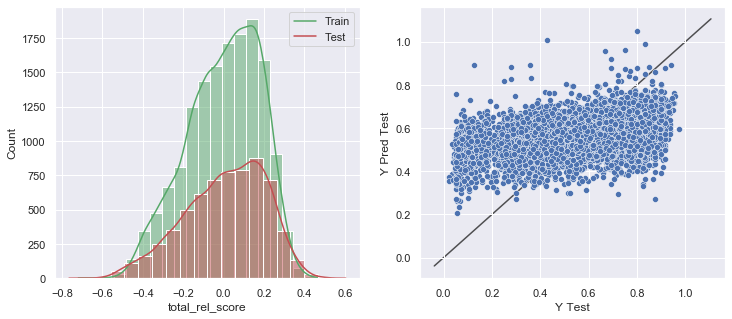

In [46]:
results_metric(model)

Training with all data:

In [47]:
%%time
full_model = BayesianRidge(verbose=True)
full_model.fit(X, y)

Convergence after  24  iterations
Wall time: 20min 30s


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=True)

## Predictions

Preprocessing Test dataset

In [54]:
# Creating dummy variables from OneHotEncoder created previosly...
dummy_test = dummy_language.transform(test[['Language']]).toarray()

# Converting to Dataframe with named columns for dummy
dummy_test = pd.DataFrame(dummy_test, columns=dummy_language.categories_[0])

# Scaling Year
test.Year = minMaxScaler.transform(test[['Year']])

# Joining dummy columns to full test dataset
test = test.join(dummy_test)

Saving Id column for submission csv file:

In [49]:
id = test.id

Applying NLP

In [32]:
%%time
test['abstract_title'] = test.Abstract+ ' '+test.Title
test['Abstract_tokens'] = get_tokens(test[['abstract_title','Language']])


Wall time: 6min 20s


In [33]:
vectorizer_values_test = vectorizer_model.transform(test['Abstract_tokens'])
test_tfidf = test.join(pd.DataFrame(vectorizer_values_test.toarray(), 
                        columns=vectorizer_model.get_feature_names())
        )

Removing same columns as train dataset:

In [34]:
test_tfidf.drop(COLS, axis=1, inplace=True)

In [50]:
test_tfidf.head()

,Year,en,es,pt,aacut,aba,abaix,abandon,abbrevi,abc,...,ência,ênfas,índic,índice,óbit,órgã,últim,último,únic,útil
0,0.933333,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.906667,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.866667,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.813333,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.973333,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
y_pred = full_model.predict(test_tfidf)
predictions = pd.DataFrame({'id':id, 'total_rel_score':y_pred})
predictions.head()

,id,total_rel_score
0,1,0.617356
1,2,0.579544
2,3,0.628192
3,4,0.593095
4,5,0.574739


In [52]:
predictions.to_csv('SampleSubmission.csv', index=False)